# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Изучение данных 

In [1]:
import pandas as pd
import math
from collections import OrderedDict

In [2]:
data = pd.read_csv('/Users/evgen/OneDrive/Рабочий стол/Моя новая профессия/Проекты/Исследование объявлений о продаже квартир/real_estate_data.csv', sep='\t')
data.info()
old_data = data # для дальнейшего сравнения оставшихся данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
display(data)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


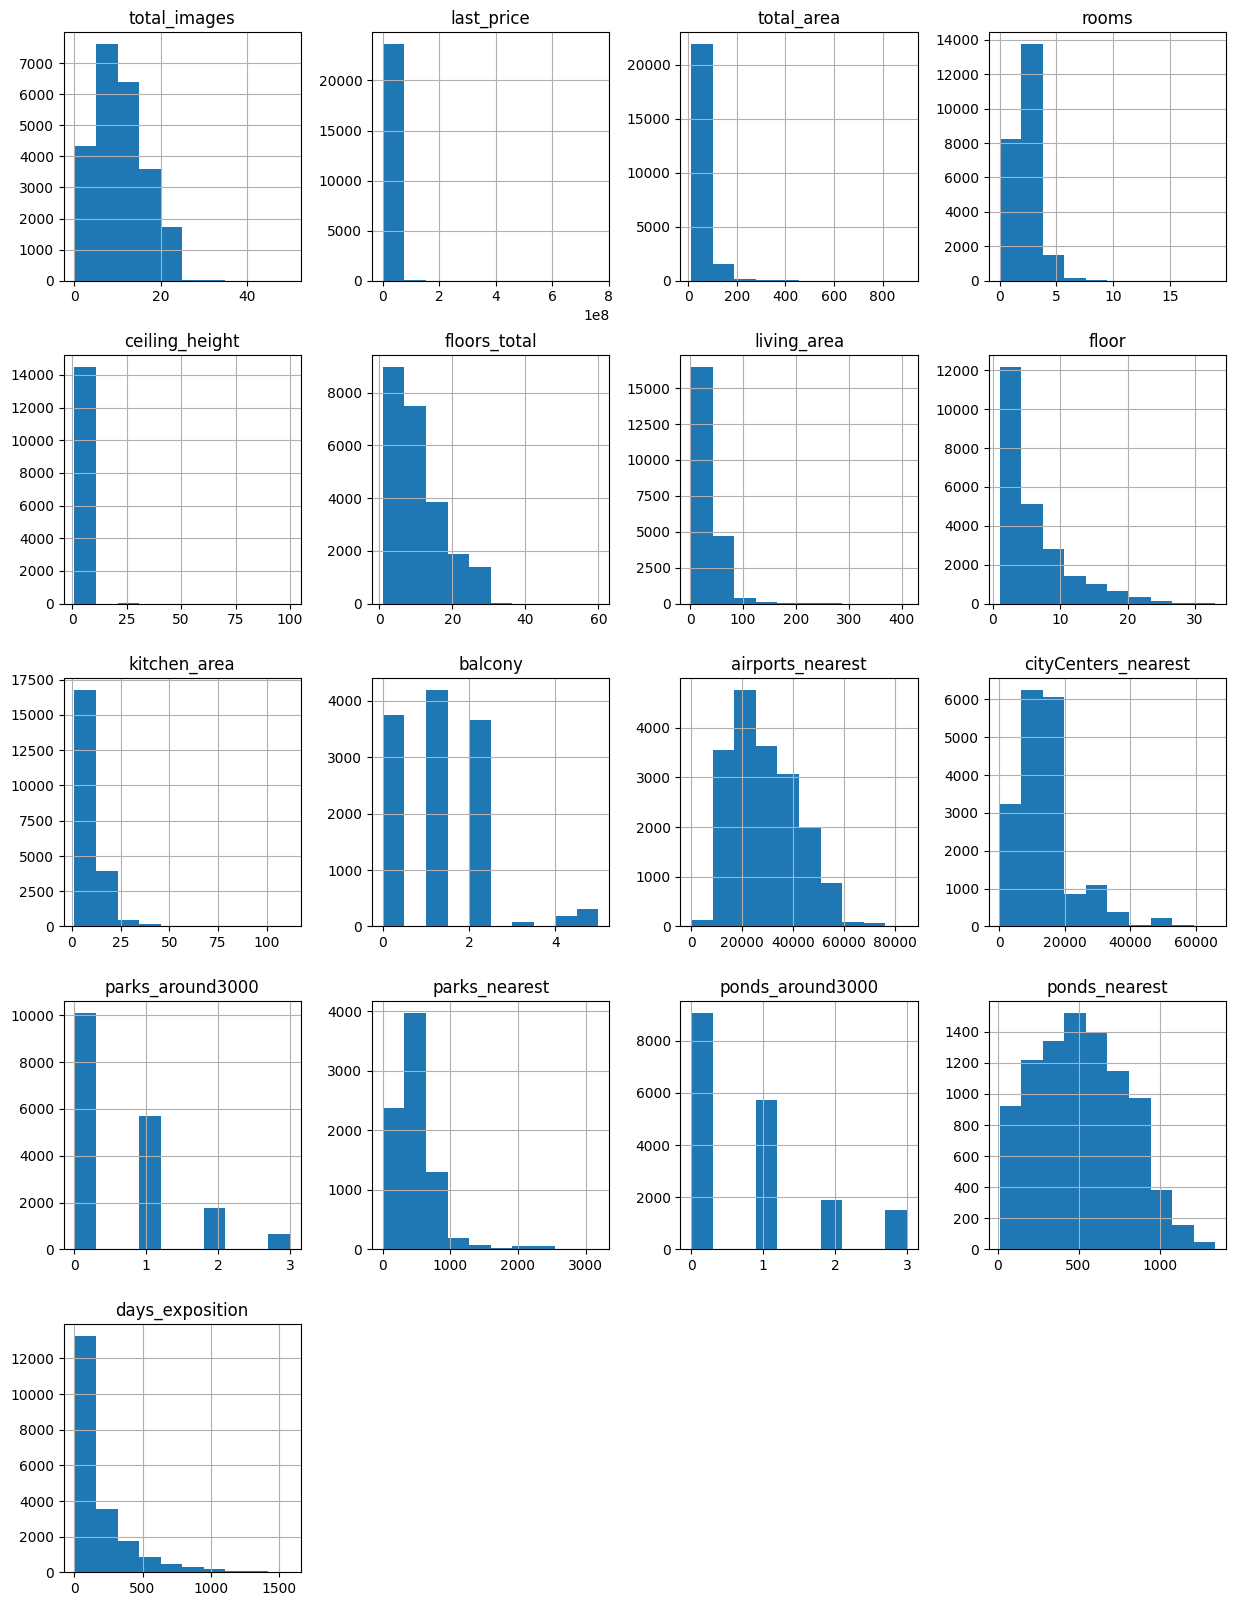

In [4]:
import matplotlib.pyplot as plt
data.hist(figsize=(15,20));

**В файле есть недостатки**

*Названия столбцов*

*Пропуски:*
- высота потолков
- этажей всего
- жилая площадь
- площадь кухни
- апартаметы
- балконы
- наименование населенного пункта
- расстояние до аэропорта
- расстояние до центра
- парки на расстоянии 3 км
- расстояние до парка
- водоемы на растоянии 3 км
- расстояние до водоема
- кол-во дней провисевшее объявление

*Формат:*
- день подачи объявления
- этажей всего
- апартаменты
- балконы
- кол-во дней провисевшее объявление

*Дубликаты:*
Проверить навазние населенных пунктов

*Странные значения:*
Проверить высоту потолков

### Предобработка данных

**Названия столбцов в питоний язык**

In [5]:
data = data.rename(columns= {'cityCenters_nearest' : 'city_centers_nearest', 'parks_around3000' : 'parks_around_3000',
                             'ponds_around3000' : 'ponds_around_3000'}) #переименовываем столбец в одну стилистику с остальными
display(data.tail(10))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
23689,13,3550000.0,35.30,2018-02-28T00:00:00,1,2.86,15.0,16.3,4,NaN,...,9.10,2.0,Санкт-Петербург,17284.0,16081.0,1.0,353.0,2.0,652.0,29.0
23690,3,5500000.0,52.00,2018-07-19T00:00:00,2,NaN,5.0,31.0,2,NaN,...,6.00,NaN,Санкт-Петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0
23691,11,9470000.0,72.90,2016-10-13T00:00:00,2,2.75,25.0,40.3,7,NaN,...,10.60,1.0,Санкт-Петербург,19424.0,4489.0,0.0,NaN,1.0,806.0,519.0
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.5,4,NaN,...,6.00,NaN,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23693,9,4600000.0,62.40,2016-08-05T00:00:00,3,2.60,9.0,40.0,8,NaN,...,8.00,0.0,Петергоф,45602.0,34104.0,1.0,352.0,1.0,675.0,239.0
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23698,4,1350000.0,32.30,2017-07-21T00:00:00,1,2.50,5.0,12.3,1,NaN,...,9.00,NaN,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Даты в читабельный вид**

In [6]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
#приводим в читабельным вид дату
print(data['first_day_exposition'].head())

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]


**Считаем пропуски**

In [7]:
print(data.isna().sum()) #считаем пропуски

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


**Пропуски в столбце Апартаменты**

In [8]:
print(data['is_apartment'].unique())
data['is_apartment'] = data['is_apartment'].fillna(False) # если клиент не отметил что у него апартаменты
# то скорее всего у него не апартаметы, соотвественно все пропуски заменяет на False
print(data['balcony'].unique())
data['balcony'] = data['balcony'].fillna(0).astype(int) # тоже самое с балконами, пропуски меняем на 0

[nan False True]
[nan  2.  0.  1.  5.  4.  3.]


In [9]:
print(data.isna().sum()) 

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


**Пропуски в столбце Этажей в доме**

In [10]:
print(data['floors_total'].unique())

[16. 11.  5. 14. 12. 26. 24. 27.  9.  6. 17. 25.  3. 23. 19. 18.  4. 22.
  8.  2. 10.  7. 13. 15. nan 20. 28. 36. 21. 35. 34. 60.  1. 29. 33. 52.
 37.]


In [11]:
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median()) # пропуски заменяем медианным значением
data['floors_total'] = data['floors_total'].astype(int) # меняем тип данных на целое число, т.к не бывает дробных этажей
print(data.query('floors_total < floor')) # проверяем нет ли этажей квартиры выше чем домов
data.loc[(data['floors_total'] < data['floor']), 'floors_total'] = data['floor'] # меняем на этаж 


       total_images  last_price  total_area first_day_exposition  rooms  \
457               4   9788348.0       70.80           2015-08-01      2   
2392              7   5395770.0       53.00           2017-06-29      2   
2846              4   2325000.0       27.80           2016-09-21      1   
3031              9   6400000.0       56.70           2018-03-27      2   
3438             10   4100000.0       38.00           2018-04-14      1   
4617              4   4275062.0       61.20           2017-04-27      2   
4848             15  13000000.0       98.00           2017-02-08      3   
5146             10   3085024.0       33.33           2018-10-06      1   
5187              5   3300000.0       25.40           2018-11-02      0   
5784              4   4262941.0       59.90           2017-04-02      2   
5958              1   3200000.0       30.30           2018-09-07      0   
6030              3  10900000.0      116.23           2017-05-05      4   
7922              3   542

**Пропуски в названии Наименование местности**

In [12]:
data = data.dropna(subset=['locality_name']) # т.к здесь всего 49 пропусков проще всего будет удалить их, т.к на анализ
# не повлияет
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total                0
living_area              1898
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5534
city_centers_nearest     5511
parks_around_3000        5510
parks_nearest           15586
ponds_around_3000        5510
ponds_nearest           14565
days_exposition          3180
dtype: int64


In [13]:
data.shape[0]

23650

**Проверка данных в столбце Высота потолков**

In [14]:
print(data['ceiling_height'].sort_values().unique())

[  1.     1.2    1.75   2.     2.2    2.25   2.3    2.34   2.4    2.45
   2.46   2.47   2.48   2.49   2.5    2.51   2.52   2.53   2.54   2.55
   2.56   2.57   2.58   2.59   2.6    2.61   2.62   2.63   2.64   2.65
   2.66   2.67   2.68   2.69   2.7    2.71   2.72   2.73   2.74   2.75
   2.76   2.77   2.78   2.79   2.8    2.81   2.82   2.83   2.84   2.85
   2.86   2.87   2.88   2.89   2.9    2.91   2.92   2.93   2.94   2.95
   2.96   2.97   2.98   2.99   3.     3.01   3.02   3.03   3.04   3.05
   3.06   3.07   3.08   3.09   3.1    3.11   3.12   3.13   3.14   3.15
   3.16   3.17   3.18   3.2    3.21   3.22   3.23   3.24   3.25   3.26
   3.27   3.28   3.29   3.3    3.31   3.32   3.33   3.34   3.35   3.36
   3.37   3.38   3.39   3.4    3.42   3.43   3.44   3.45   3.46   3.47
   3.48   3.49   3.5    3.51   3.52   3.53   3.54   3.55   3.56   3.57
   3.58   3.59   3.6    3.62   3.63   3.65   3.66   3.67   3.68   3.69
   3.7    3.75   3.76   3.78   3.8    3.82   3.83   3.84   3.85   3.86
   3.8

In [15]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median()) # пропущенные значения меняем на медиану
# т.к среднее не подойдет из-за вброса
data.loc[(data['ceiling_height'] > 10), 'ceiling_height'] = data['ceiling_height'] /10 # некоторые данные записаны неверно такие
# как 25, 32 метра, поэтому делим их на 10 и получаем стандартные потолки
data = data.query('ceiling_height > 2.2 and ceiling_height < 6') # делаем срез и убираем слишком
# маленькие и слишком большие потолки
print(data['ceiling_height'].sort_values(ascending=False).unique())

[5.8  5.6  5.5  5.3  5.2  5.   4.9  4.8  4.7  4.65 4.5  4.45 4.4  4.37
 4.3  4.25 4.2  4.19 4.15 4.14 4.1  4.06 4.   3.98 3.95 3.93 3.9  3.88
 3.87 3.86 3.85 3.84 3.83 3.82 3.8  3.78 3.76 3.75 3.7  3.69 3.68 3.67
 3.66 3.65 3.63 3.62 3.6  3.59 3.58 3.57 3.56 3.55 3.54 3.53 3.52 3.51
 3.5  3.49 3.48 3.47 3.46 3.45 3.44 3.43 3.42 3.4  3.39 3.38 3.37 3.36
 3.35 3.34 3.33 3.32 3.31 3.3  3.29 3.28 3.27 3.26 3.25 3.24 3.23 3.22
 3.21 3.2  3.18 3.17 3.16 3.15 3.14 3.13 3.12 3.11 3.1  3.09 3.08 3.07
 3.06 3.05 3.04 3.03 3.02 3.01 3.   2.99 2.98 2.97 2.96 2.95 2.94 2.93
 2.92 2.91 2.9  2.89 2.88 2.87 2.86 2.85 2.84 2.83 2.82 2.81 2.8  2.79
 2.78 2.77 2.76 2.75 2.74 2.73 2.72 2.71 2.7  2.69 2.68 2.67 2.66 2.65
 2.64 2.63 2.62 2.61 2.6  2.59 2.58 2.57 2.56 2.55 2.54 2.53 2.52 2.51
 2.5  2.49 2.48 2.47 2.46 2.45 2.4  2.34 2.3  2.26 2.25]


In [16]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1896
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2265
balcony                     0
locality_name               0
airports_nearest         5523
city_centers_nearest     5500
parks_around_3000        5499
parks_nearest           15570
ponds_around_3000        5499
ponds_nearest           14549
days_exposition          3176
dtype: int64


**Пропуски в столбце Жилая площадь**

In [17]:
area = data.loc[:,['living_area','kitchen_area', 'total_area']] # создаем переменную и добавляем туда столбцы с данными по площади
area = area.dropna(subset=['living_area','kitchen_area']) # удаляем оттуда пропущенные значения для чистоты полученных данных
ratio_living = sum(area['living_area']) / sum(area['total_area']) # вычисляем долю жилой площади от общей
ratio_kitchen = sum(area['kitchen_area']) / sum(area['total_area']) # вычисляем долю площади кухни от общей
print(f'Доля жилой площади: {ratio_living:.1%}\nДоля площади кухни {ratio_kitchen:.1%}')

Доля жилой площади: 57.2%
Доля площади кухни 17.4%


In [18]:
for i in data['total_area'].unique(): # проходим по уникальным значениям
    data.loc[(data['total_area'] == i) & (data['living_area'].isna()), 'living_area'] = \
    data['total_area'] * ratio_living # и заполняем пропуски в living_area согласно доли от total_area высчитанное ранее 
    data.loc[(data['total_area'] == i) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data['total_area'] * ratio_kitchen # тоже самое заполняем пропуски в living_area согласно доли от total_area высчитанное ранее

data['living_area'] = data['living_area'].round(2) # округляем до двух чисел после запятой
data['kitchen_area'] = data['kitchen_area'].round(2)
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5523
city_centers_nearest     5500
parks_around_3000        5499
parks_nearest           15570
ponds_around_3000        5499
ponds_nearest           14549
days_exposition          3176
dtype: int64


**Дубликаты в Наименовании поселений**

In [19]:
name_dict = {'городской поселок' : 'городской посёлок', 'коттеджный поселок' : 'коттеджный посёлок', 'поселок' : 'посёлок',
            'поселок городского типа' : 'городской посёлок', 'посёлок городского типа' : 'городской посёлок', 
            'посёлок при железнодорожной станции' : 'посёлок станции', 'поселок станции' : 'посёлок станции',
            'садоводческое некоммерческое товарищество' : 'садовое товарищество', 
             'городской посёлок городского типа' : 'городской посёлок', 
            'городской городской городской городской городской посёлок Рябово' : 'городской посёлок Рябово',
            'городской городской городской городской посёлок Рябово' : 'городской посёлок Рябово'}
# создаем словарь для переименования неявных дубликатов
data['locality_name'] = data['locality_name'].replace(name_dict, regex=True) # делаем замену неявных дубликатов, используя наш словарь
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской посёлок Большая Ижора', 'городской посёлок Будогощь',
       'городской посёлок Важины', 'городской посёлок Виллози',
       'городской посёлок Вознесенье', 'городской посёлок Вырица',
       'городской посёлок Красный Бор', 'городской посёлок Кузнечное',
       'городской посёлок Кузьмоловский', 'городской посёлок Лебяжье',
       'городской посёлок Лесогорский', 'городско

**Проверка на аномалии в цене**

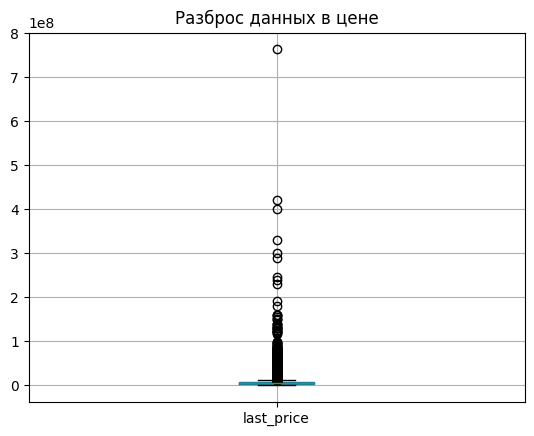

count    2.343200e+04
mean     5.895137e+06
std      4.552000e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.600000e+06
75%      6.700000e+06
max      3.999000e+07
Name: last_price, dtype: float64
430000.0
39990000.0


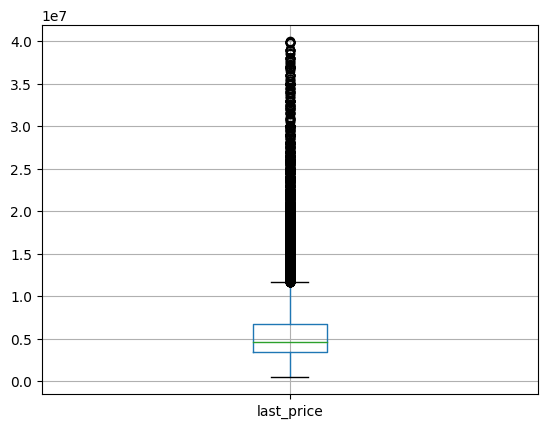

23432

In [20]:
data.boxplot(column='last_price')
plt.title('Разброс данных в цене')
plt.show()
data = data.query('12190 < last_price < 40000000') # убираем аномалии
print(data['last_price'].describe())
print(data['last_price'].min()) # выделяю отдельно чтобы видно было полностью число
print(data['last_price'].max()) # выделяю отдельно чтобы видно было полностью число
data.boxplot(column='last_price')
plt.show()
data.shape[0] # проверяем оставшееся

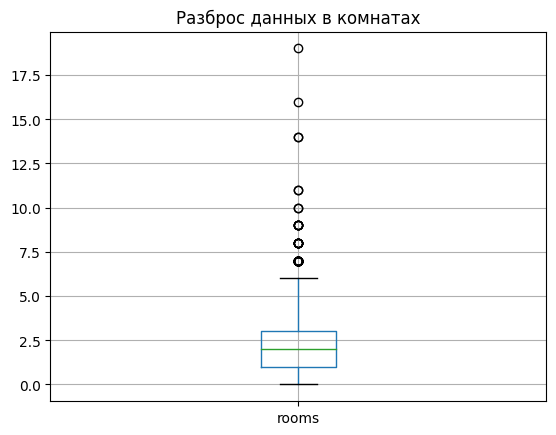

count    23424.000000
mean         2.047302
std          1.026931
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: rooms, dtype: float64


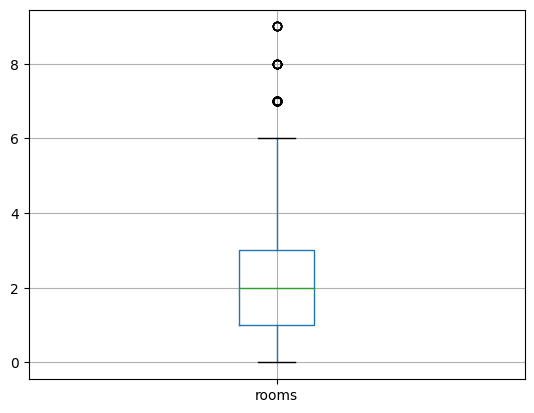

23424

In [21]:
data.boxplot(column='rooms')
plt.title('Разброс данных в комнатах')
plt.show()
data = data.query('rooms < 10') # убираем аномалии
print(data['rooms'].describe())
data.boxplot(column='rooms')
plt.show()
data.shape[0] # проверяем оставшееся

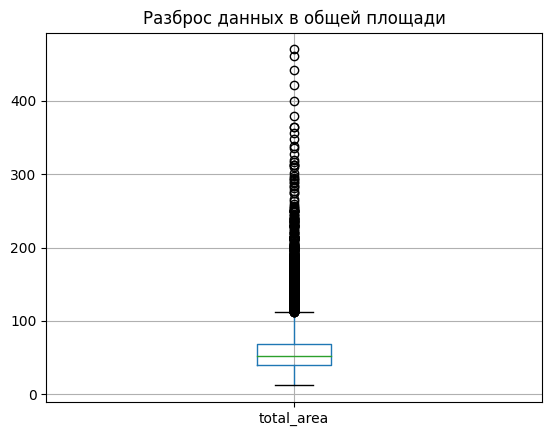

count    23369.000000
mean        58.597012
std         28.251297
min         20.100000
25%         40.000000
50%         52.000000
75%         69.000000
max        297.500000
Name: total_area, dtype: float64


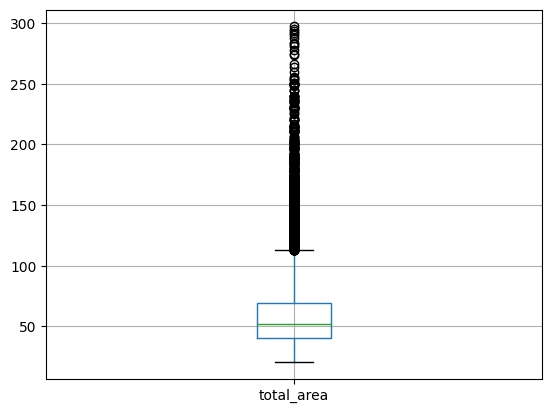

23369

In [22]:
data.boxplot(column='total_area')
plt.title('Разброс данных в общей площади')
plt.show()
data = data.query('20 < total_area < 300') # убираем аномалии
print(data['total_area'].describe())
data.boxplot(column='total_area')
plt.show()
data.shape[0] # проверяем оставшееся

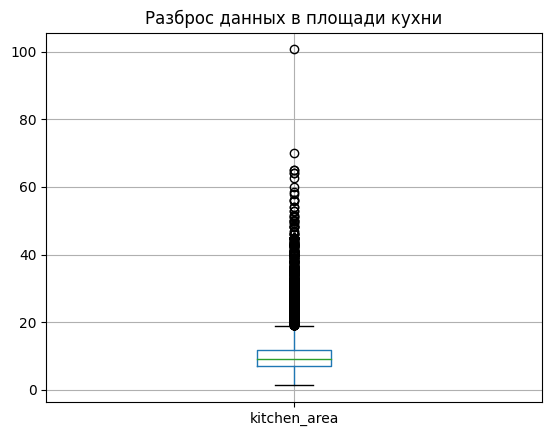

count    23264.000000
mean        10.310885
std          5.208009
min          4.010000
25%          7.000000
50%          9.000000
75%         11.900000
max         65.000000
Name: kitchen_area, dtype: float64


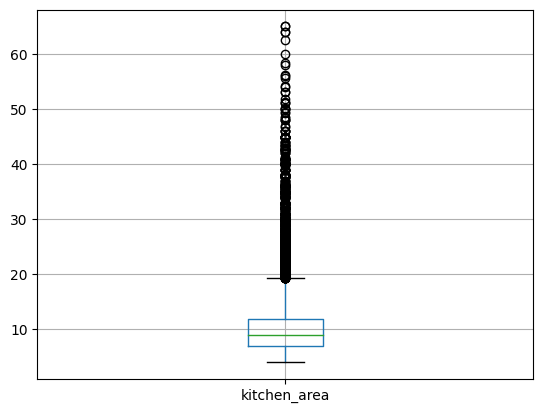

23264

In [23]:
data.boxplot(column='kitchen_area')
plt.title('Разброс данных в площади кухни')
plt.show()
data = data.query('4 < kitchen_area < 70') # убираем аномалии
print(data['kitchen_area'].describe())
data.boxplot(column='kitchen_area')
plt.show()
data.shape[0] # проверяем оставшееся

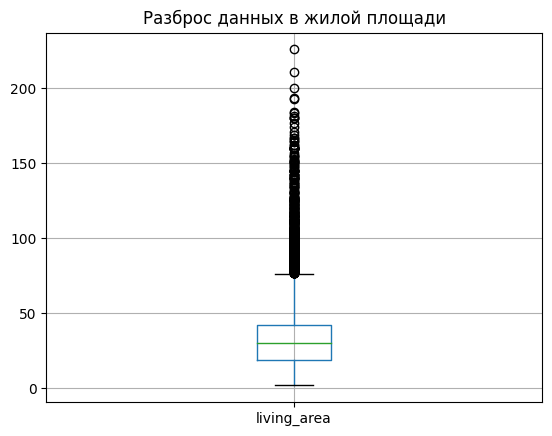

count    21276.000000
mean        35.407948
std         18.214536
min         16.020000
25%         21.170000
50%         31.000000
75%         43.000000
max        193.500000
Name: living_area, dtype: float64


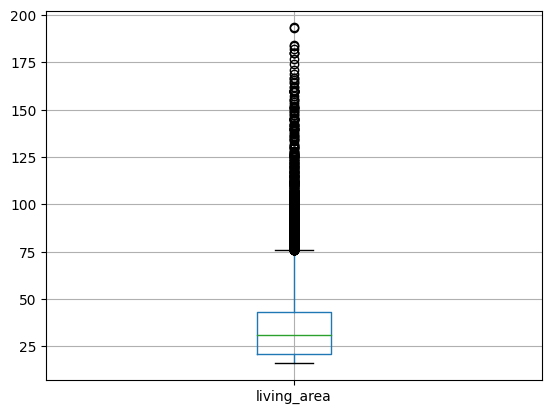

21276

In [24]:
data.boxplot(column='living_area')
plt.title('Разброс данных в жилой площади')
plt.show()
data = data.query('16 < living_area < 200') # убираем аномалии
print(data['living_area'].describe())
data.boxplot(column='living_area')
plt.show()
data.shape[0] # проверяем оставшееся

In [25]:
print(f'Доля оставшихся данных: {(data.shape[0] / old_data.shape[0]):.2f}')

Доля оставшихся данных: 0.90


### Добавление в таблицу новые столбцы

**Цена за 1 кв.м.**

In [26]:
data['price_one_m2'] = (data['last_price'] / data['total_area']).round(2)
print(data['price_one_m2'].value_counts())

100000.00    224
83333.33      63
75000.00      53
80000.00      49
125000.00     48
            ... 
113452.19      1
95046.95       1
126829.27      1
171818.18      1
75279.46       1
Name: price_one_m2, Length: 13516, dtype: int64


**День недели публикации**

In [27]:
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
print(data['weekday_exposition'].value_counts())

3    3858
1    3769
4    3607
2    3583
0    3183
5    1741
6    1535
Name: weekday_exposition, dtype: int64


**Месяц публикации**

In [28]:
data['month_exposition'] = data['first_day_exposition'].dt.month
print(data['month_exposition'].value_counts())

2     2405
3     2365
11    2145
4     2143
10    1898
9     1751
8     1574
6     1557
7     1494
12    1478
1     1327
5     1139
Name: month_exposition, dtype: int64


**Год публикации**

In [29]:
data['year_exposition'] = data['first_day_exposition'].dt.year
print(data['year_exposition'].value_counts())

2018    7651
2017    7344
2019    2623
2016    2480
2015    1051
2014     127
Name: year_exposition, dtype: int64


**Тип этажа**

In [30]:
def floor_type(floor):
    if floor['floor'] == 1:
        return 'первый'
    if floor['floor'] == floor['floors_total']:
        return 'последний'
    elif floor['floor']:
        return 'другой'
data['floor_type'] = data.apply(floor_type, axis=1)
# создаем функцию для определения типа этажа
print(data['floor_type'].value_counts()) # проверяем

другой       15517
последний     3083
первый        2676
Name: floor_type, dtype: int64


**Расстояние до центра города**

In [31]:
data['city_centers_nearest_km'] = (data['city_centers_nearest'] / 1000).round() # создаем новым столбец расстояние до центра
# города с данными в км 
print(data['city_centers_nearest_km'].value_counts())

12.0    1441
15.0    1441
13.0    1355
14.0    1169
16.0    1131
        ... 
63.0       1
61.0       1
60.0       1
45.0       1
62.0       1
Name: city_centers_nearest_km, Length: 61, dtype: int64


In [32]:
data.info() # проверяем что у нас осталось

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21276 entries, 0 to 23697
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             21276 non-null  int64         
 1   last_price               21276 non-null  float64       
 2   total_area               21276 non-null  float64       
 3   first_day_exposition     21276 non-null  datetime64[ns]
 4   rooms                    21276 non-null  int64         
 5   ceiling_height           21276 non-null  float64       
 6   floors_total             21276 non-null  int64         
 7   living_area              21276 non-null  float64       
 8   floor                    21276 non-null  int64         
 9   is_apartment             21276 non-null  bool          
 10  studio                   21276 non-null  bool          
 11  open_plan                21276 non-null  bool          
 12  kitchen_area             21276 n

### Проведите исследовательский анализ данных

count    21276.000000
mean        60.912776
std         28.291562
min         23.060000
25%         42.400000
50%         54.500000
75%         71.000000
max        297.500000
Name: total_area, dtype: float64


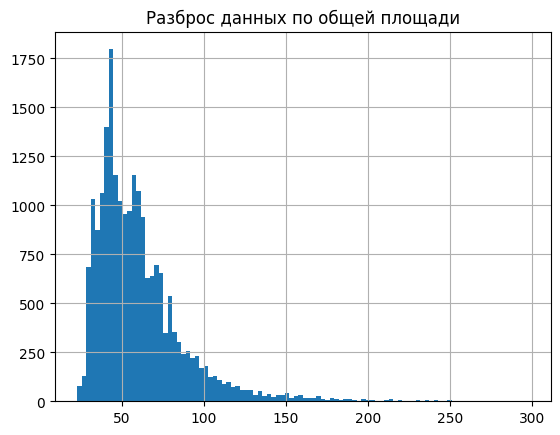

In [33]:
print(data['total_area'].describe())
data['total_area'].hist(bins=100)
plt.title('Разброс данных по общей площади');

In [34]:
data.pivot_table(index='studio', values='total_area', aggfunc=['mean','count'])

,mean,count
,total_area,total_area
studio,,
False,61.052602,21180
True,30.063750,96


Проверяем маленькие по площади недвижимость, видим что среднее по студии идем 30 квадратов, по остальным 63 квадрата, что в полне можно считать за нормальные показатели

In [35]:
data.pivot_table(index='rooms', values='total_area', aggfunc=['mean','count'])

,mean,count
,total_area,total_area
rooms,,
0,29.406615,130
1,38.686651,6016
2,55.792355,7861
3,76.884762,5731
4,103.113872,1126
5,143.475851,282
6,173.068293,82
7,189.957895,38


In [36]:
data.query('rooms == 0').pivot_table(index='rooms', values='studio', aggfunc=['mean','count'])

,mean,count
,studio,studio
rooms,,
0,0.684615,130


Также смотрим расклад общей площади в зависимости от кол-ва комнат и видим что в подавляющем большинстве 1-3 комнат, что также можно считать в полне нормальными данными. Данные с 0 комнатами относятся к студиям.

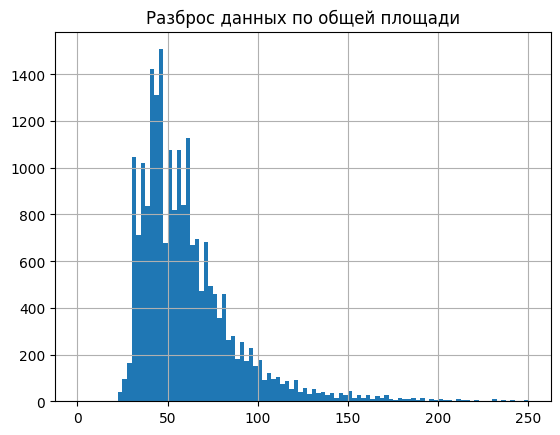

In [37]:
data['total_area'].hist(bins=100, range=(0,250))
plt.title('Разброс данных по общей площади');

Делаем гистограмму исключающую слишком большие значения и видим в полне стандартные данные.

count    21276.000000
mean        35.407948
std         18.214536
min         16.020000
25%         21.170000
50%         31.000000
75%         43.000000
max        193.500000
Name: living_area, dtype: float64


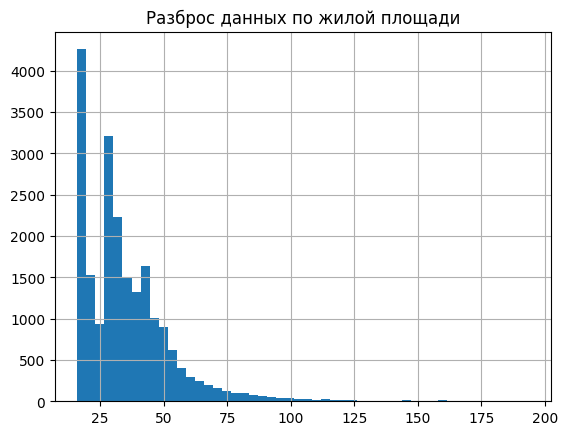

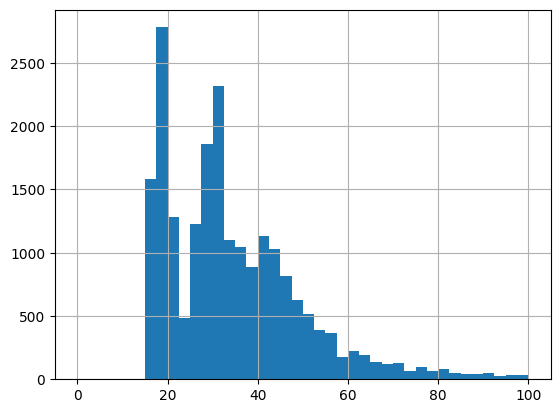

In [38]:
print(data['living_area'].describe())
data['living_area'].hist(bins=50) 
plt.title('Разброс данных по жилой площади');
plt.show()
data['living_area'].hist(bins=40, range=(0,100));

In [39]:
data.pivot_table(index='studio', values='living_area', aggfunc=['median','count'])

,median,count
,living_area,living_area
studio,,
False,31.00,21180
True,18.95,96


Пики у нас 18-35 кв.м. Что в полне можно считать нормальным учитывая что у нас превалируют 1 и 2 комнатные квартиры.

count    21276.000000
mean        10.358069
std          5.308454
min          4.010000
25%          7.000000
50%          9.000000
75%         12.000000
max         65.000000
Name: kitchen_area, dtype: float64


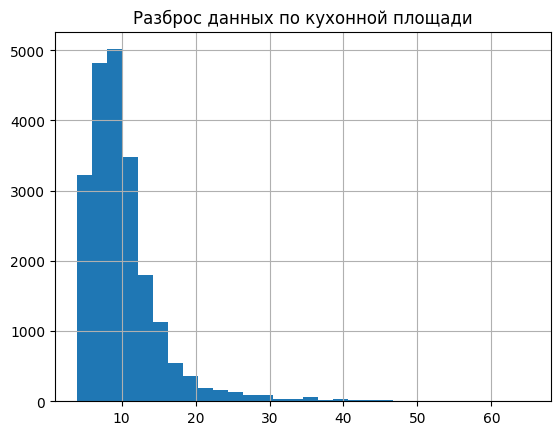

In [40]:
print(data['kitchen_area'].describe())
data['kitchen_area'].hist(bins=30)
plt.title('Разброс данных по кухонной площади');

Здесь у нас пики 7-12 кв.м. что вполне нормально.

count    2.127600e+04
mean     6.095678e+06
std      4.613735e+06
min      4.300000e+05
25%      3.550000e+06
50%      4.800000e+06
75%      6.990000e+06
max      3.999000e+07
Name: last_price, dtype: float64


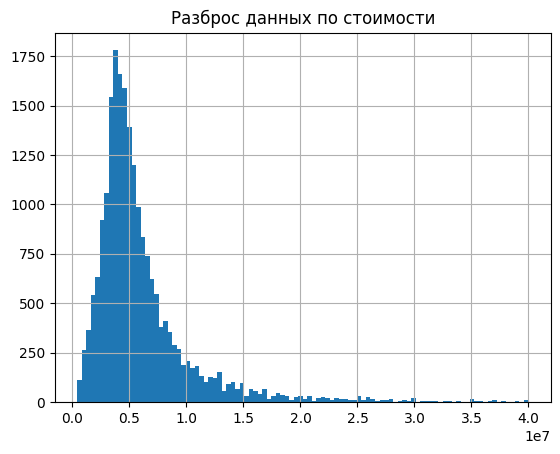

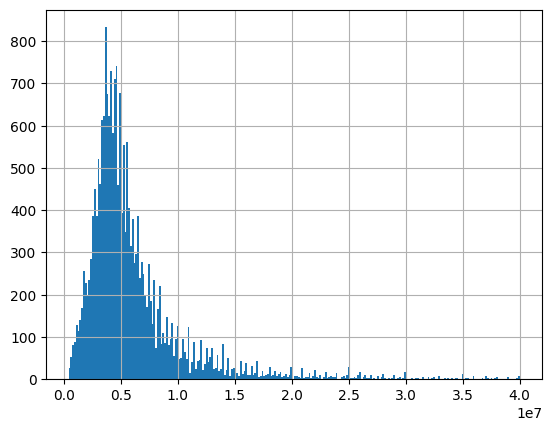

In [41]:
print(data['last_price'].describe())
data['last_price'].hist(bins=100) 
plt.title('Разброс данных по стоимости')
plt.show()
data['last_price'].hist(bins=250)
plt.show();

Видим что пики по цене у нас от 3 млн до 7 млн, что в полне нормально с учетом всей Ленинградской области

count    21276.000000
mean         2.147302
std          1.005469
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: rooms, dtype: float64


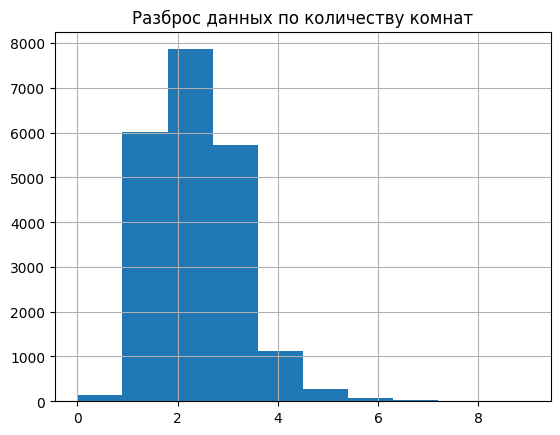

In [42]:
print(data['rooms'].describe())
data['rooms'].hist()
plt.title('Разброс данных по количеству комнат');

1-3 комнатные превалируют. Что в принципе выяснили выше пока проверяли общую площадь

count    21276.000000
mean         2.695883
std          0.216246
min          2.250000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.800000
Name: ceiling_height, dtype: float64


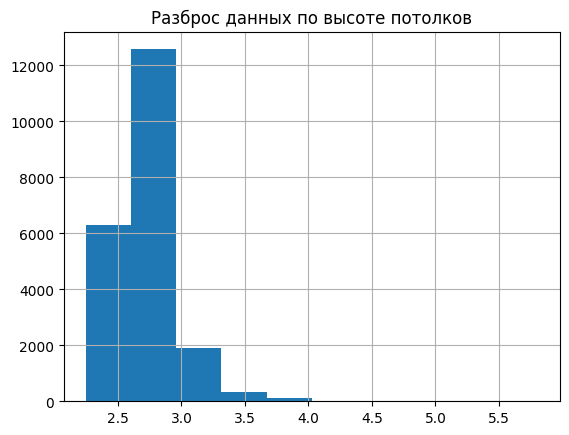

In [43]:
print(data['ceiling_height'].describe())
data['ceiling_height'].hist()
plt.title('Разброс данных по высоте потолков');

2,60 м - 2,70 м вполне стандартная высота потолков

count    21276.000000
mean         5.714937
std          4.727071
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64


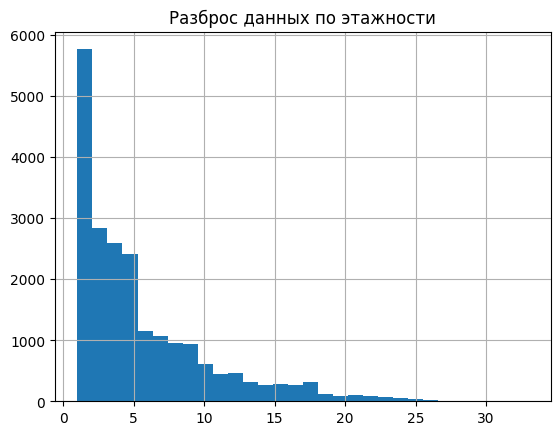

In [44]:
print(data['floor'].describe())
data['floor'].hist(bins=30)
plt.title('Разброс данных по этажности');

2-8 этажи превалируют считаю нормальным с учетом большого кол-ва старого жил. фонда

count      21276
unique         3
top       другой
freq       15517
Name: floor_type, dtype: object


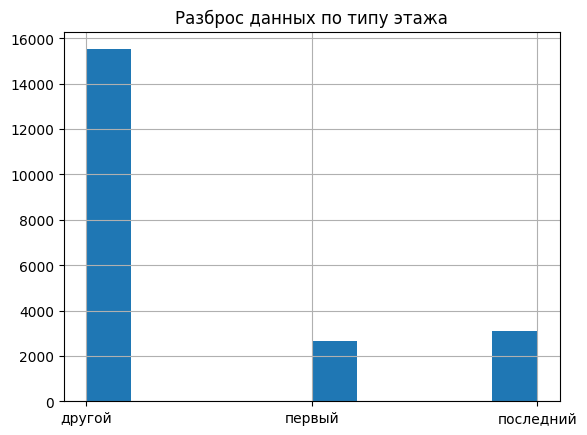

In [45]:
print(data['floor_type'].describe())
data['floor_type'].hist()
plt.title('Разброс данных по типу этажа');

Больше всего других этажей что в полне объяснимо что их в принципе больше

count    21276.000000
mean        10.364730
std          6.396987
min          1.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         60.000000
Name: floors_total, dtype: float64


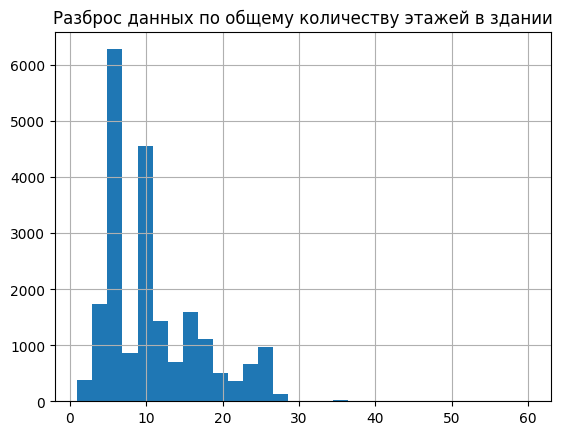

In [46]:
print(data['floors_total'].describe())
data['floors_total'].hist(bins=30)
plt.title('Разброс данных по общему количеству этажей в здании');

пики 5 этажей, 9 этажей здания что объяснимо старым жил.фондом

count    16433.000000
mean     14192.451652
std       8668.881344
min        181.000000
25%       9234.000000
50%      13056.000000
75%      16219.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64


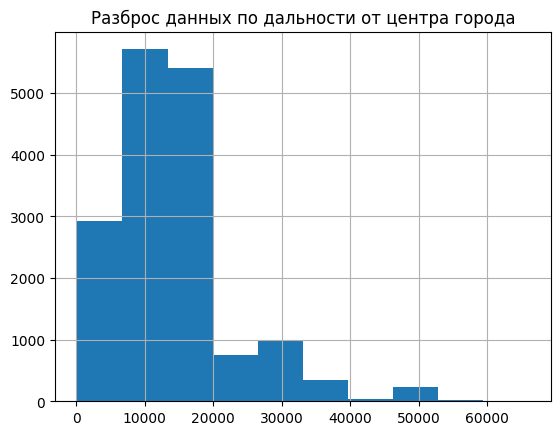

In [47]:
print(data['city_centers_nearest'].describe())
data['city_centers_nearest'].hist()
plt.title('Разброс данных по дальности от центра города');

В основном объявления близ центра города в пределах 10-20 км. Это вполне понятно т.к сам центр Санкт-Петербурга растянут.

count    16413.000000
mean     28737.750564
std      12586.150457
min          0.000000
25%      18539.000000
50%      26736.000000
75%      37180.000000
max      84869.000000
Name: airports_nearest, dtype: float64


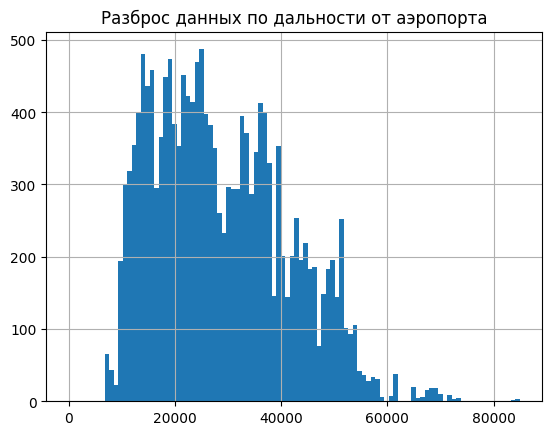

In [48]:
print(data['airports_nearest'].describe())
data['airports_nearest'].hist(bins=100)
plt.title('Разброс данных по дальности от аэропорта'); # увеличиваем число корзин чтобы видеть начала гистограммы

Больше всего объявлений в пределах 15-40 км от аэропорта.

count    7354.000000
mean      493.277944
std       340.178558
min         1.000000
25%       292.250000
50%       457.500000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64


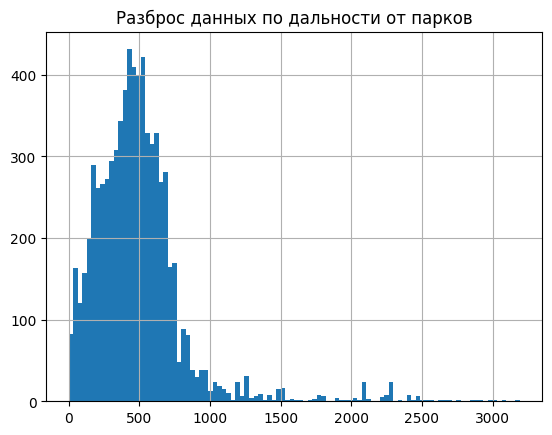

In [49]:
print(data['parks_nearest'].describe())
data['parks_nearest'].hist(bins=100)
plt.title('Разброс данных по дальности от парков');

Больше всего объявлений с наличием парка в районе 300-600 метров.

count    21276.000000
mean         6.390346
std          3.496913
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_exposition, dtype: float64


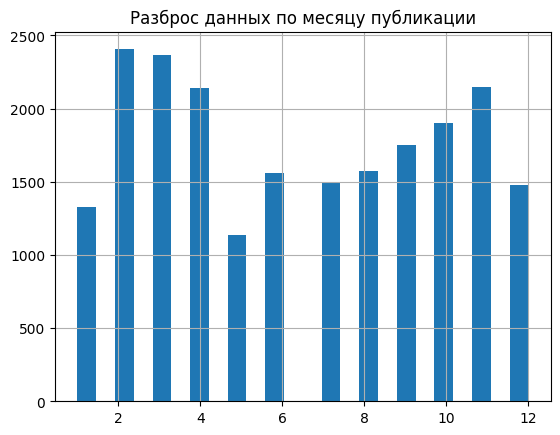

In [50]:
print(data['month_exposition'].describe())
data['month_exposition'].hist(bins=24)
plt.title('Разброс данных по месяцу публикации');

Видно что в феврале, марте, апреле и ноябре наиболее чаще выкладывают объявления

count    21276.000000
mean         2.578116
std          1.786556
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: weekday_exposition, dtype: float64


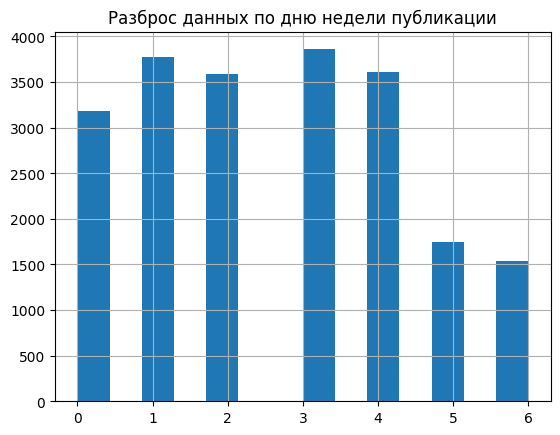

In [51]:
print(data['weekday_exposition'].describe())
data['weekday_exposition'].hist(bins=14)
plt.title('Разброс данных по дню недели публикации');

Видно что в **будние дни и вс** значительно **больше** выкладывают объявления чем пт, сб

count    18328.000000
mean       181.340081
std        220.304838
min          1.000000
25%         45.000000
50%         96.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64
Среднее кол-во дней: 181.0 Медианное кол-во дней: 96.0


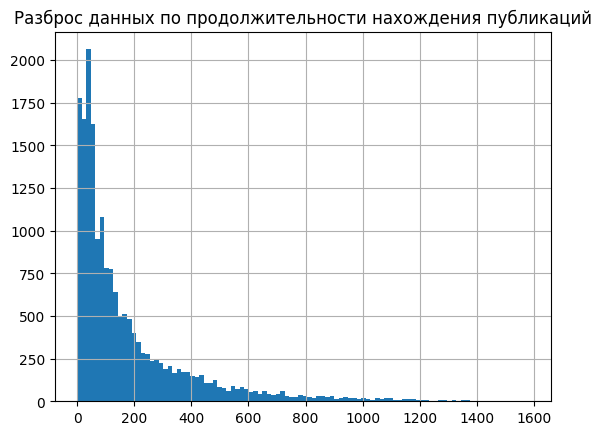

In [52]:
print(data['days_exposition'].describe())
data['days_exposition'].hist(bins=100)
plt.title('Разброс данных по продолжительности нахождения публикаций');

print('Среднее кол-во дней:', data['days_exposition'].mean().round(), 'Медианное кол-во дней:', data['days_exposition'].median())

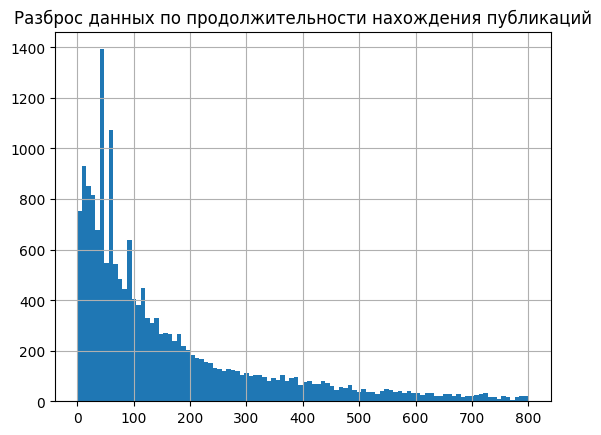

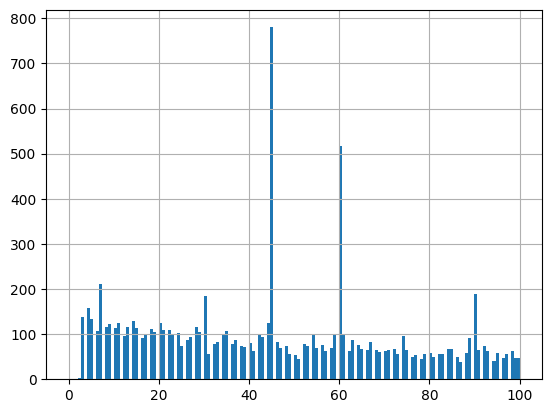

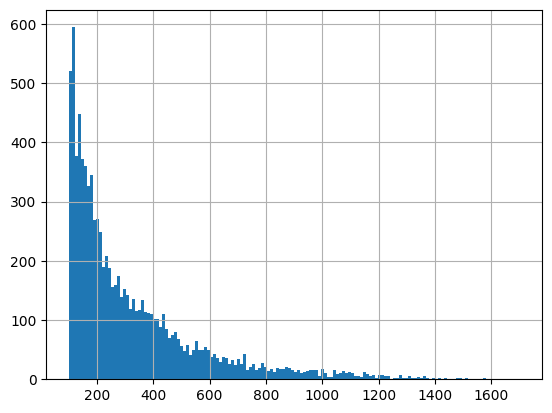

In [53]:
data['days_exposition'].hist(bins=100, range=(0,800))
plt.title('Разброс данных по продолжительности нахождения публикаций')
plt.show();
data['days_exposition'].hist(bins=150, range=(0,100))
plt.show();
data['days_exposition'].hist(bins=150, range=(100,1700))
plt.show();

В среднем продажи от **45-231 дней** можно считать **обычными**. Продажи **меньше чем за 40 дней** можно считать **быстрыми**, а вот продажи **сверх 800 дней** можно считать **необычайно долгими**.

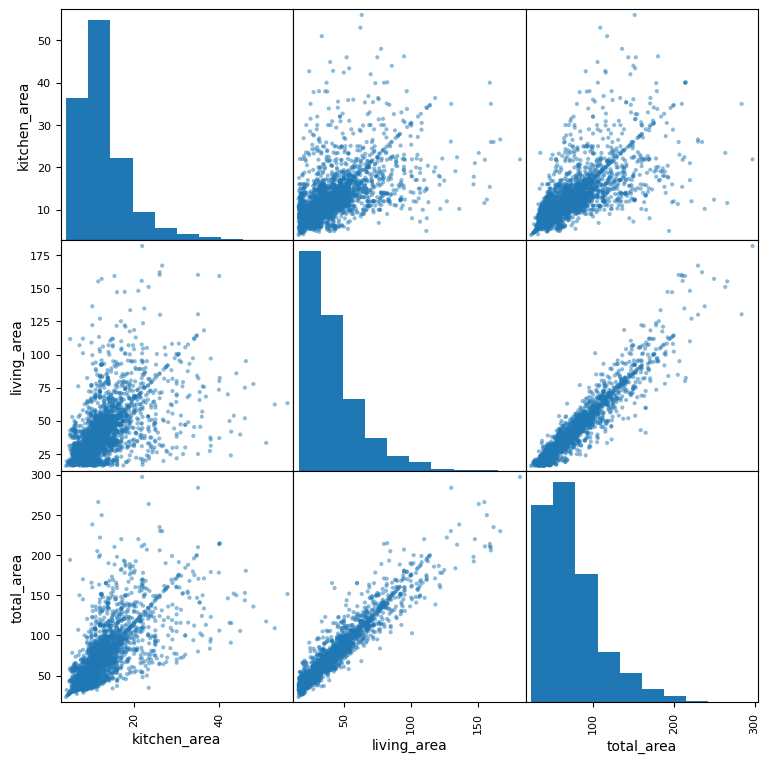

In [54]:
area_price = data.pivot_table(index='last_price', values=['total_area', 'living_area', 'kitchen_area'], aggfunc='median')
pd.plotting.scatter_matrix(area_price, figsize=(9,9))
plt.show();

Видим что цена напрямую зависит от площади недвижимости

0.4877622074604487


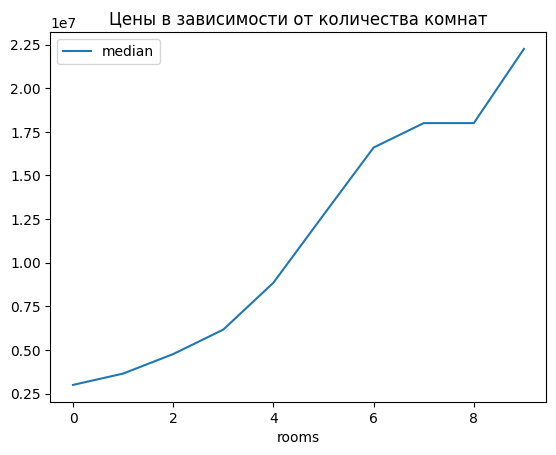

In [55]:
print(data['last_price'].corr(data['rooms']))
rooms_price = data.query('rooms != 12 and rooms != 15').pivot_table(index='rooms', values='last_price', aggfunc='median')
# срез делаем т.к этаж 12 и 15 сильно выбивались из данных
rooms_price.columns = ['median']
rooms_price.plot()
plt.title('Цены в зависимости от количества комнат');

Цена однозначно зависит от кол-ва комнат в недвижимости

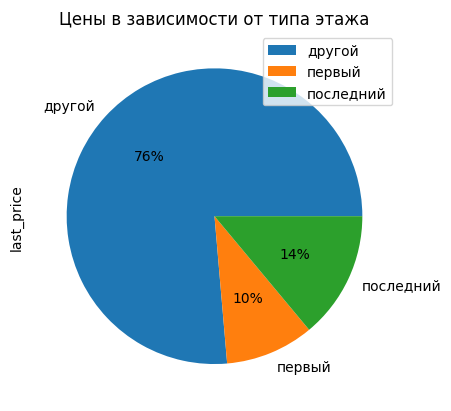

In [56]:
floor_type_price = data.groupby(['floor_type']).sum().plot(kind='pie', y='last_price', autopct='%1.0f%%')
plt.title('Цены в зависимости от типа этажа');

Видим что первый и последний этажи не пользуются спросом оттого и цена на них ниже чем на другие этажи. также если сравнивать первый и последний этажи то видим что менее предпочитаемый это **первый этаж**.

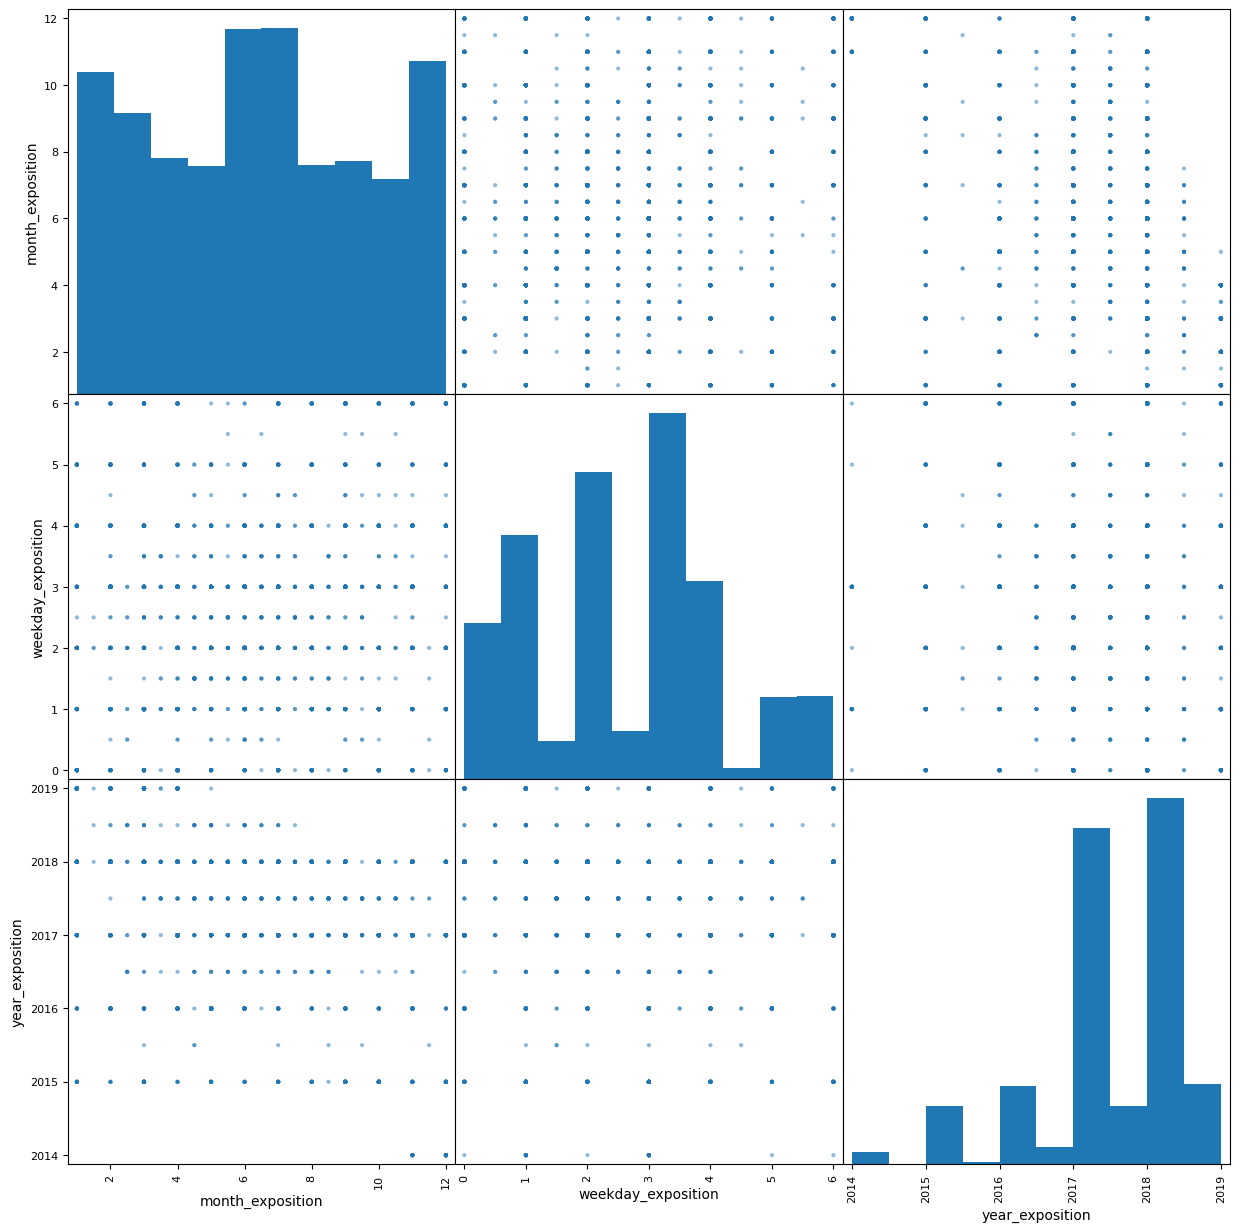

In [57]:
day_price = data.pivot_table(index='last_price', values=['weekday_exposition', 'month_exposition', 'year_exposition'], aggfunc='median')
pd.plotting.scatter_matrix(day_price, figsize=(15,15));

Видим что в в **первом полугодии** каждых из годов **цена** на недвижимость **выше** в несколько раз чем во втором полугодии.
Также видим что в **2017 год резко возрасли цены**. До этого с 2014-2016 цены планомерно росли.  

**Январь, декабрь и летние месяцы** выделяются самыми **высокими ценами**. 

**В пятницу и субботу менее** высокие цены на недвижимость. 

In [58]:
too_locality_name = (data.pivot_table(index='locality_name', values='price_one_m2', aggfunc='count')
                     .sort_values(by='price_one_m2', ascending=False)[0:10])
too_locality_name = too_locality_name.rename(columns={'price_one_m2': 'count'})

mean_locality_name = (data.pivot_table(index='locality_name', values='price_one_m2', aggfunc='mean')
                      .sort_values(by='price_one_m2', ascending=False).round())

mean_price_locality_name = too_locality_name.join(mean_locality_name, on='locality_name')

print(mean_price_locality_name.sort_values(by='price_one_m2', ascending=False))

print('Средняя цена за 1 кв.м.', mean_price_locality_name['price_one_m2'].mean())

                   count  price_one_m2
locality_name                         
Санкт-Петербург    14285      111076.0
Пушкин               347      102879.0
деревня Кудрово      221       91116.0
посёлок Парголово    234       85922.0
посёлок Мурино       368       82586.0
посёлок Шушары       365       75895.0
Колпино              314       74497.0
Гатчина              299       68916.0
Всеволожск           347       68572.0
Выборг               226       57651.0
Средняя цена за 1 кв.м. 81911.0


**Из ТОП-10 по кол-ву объявлений:** средняя цена за 1 кв.м. 81 911 руб. Самые дорогая недвижимость в **Санкт-Петербурге** за 1 кв.м. 111 076 руб.. Самая дешевая в **Выборге** за 1 кв.м. 57 651 руб.


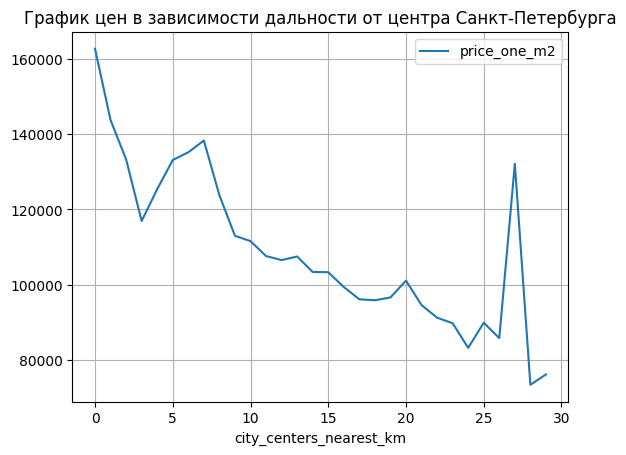

In [59]:
spb_price_km = (data.query('locality_name == "Санкт-Петербург"').pivot_table
                (index='city_centers_nearest_km', values='price_one_m2', aggfunc='mean').sort_values
                (by='city_centers_nearest_km', ascending=False).round())
spb_price_km.plot(grid=True)
plt.title('График цен в зависимости дальности от центра Санкт-Петербурга')
plt.show()

Видим что чем ближе к центру тем дороже недвижимость, также видим всплеск в районе 26 км от центра что можем объяснить г.Пушкин который второй по дороговизне за 1 кв.м из ТОП-10

### Общий вывод

На рынке недвижимости **количество объявлений** в среднем варьируется по следующим параметрам:
- общая площадь 42-71 кв.м.
- жилая площадь 21-43 кв.м.
- площадь кухни 7-12 кв.м.
- с кол-вом 1-3 комнаты
- с высотой потолков 2,60 - 2,70 м.
- на этажах со 2 по 8
- в домах с высотностью 5-15 этажностью
- с дальностью от центра 10-20 км
- с дальностью от парка 3-6 км
- с дальностью от аэропорта 15-40 км

**Период** с наибольшим количеством объявлений:
- дни недели: вс, пн, вт, ср, чт
- месяцы: февраль, март, апрель, ноябрь

В **среднем** объявления висят от **45 до 231** дней. Меньше чем за **40** дней это **быстрые продажи**. Больше **800** дней **необычайно долгие** продажи.

**Цена** зависит от:
- площади недвижимости (общей, жилой и площади кухни)
- кол-ва комнат 
- этажа (средние этажи дороже)
- периода года (зимние и летние объявления дороже) и дней недели (вс, пн, вт, ср, чт дороже объявления)
- населенного пункта (Санкт-Петербург дороже)
- расстояния от центра Санкт-Петербурга (чем ближе к центру тем дороже объявление)

*Также можно отметить значительный рост цен с 2017 года.*